In [5]:
import numpy as np
import matplotlib.pyplot as plt
import models as mod

%load_ext autoreload
%autoreload 2

In [17]:
from IPython.display import clear_output
def clf():
    clear_output(wait=True)

In [140]:
N = 3
Nj = 20

net = mod.Network(N=N, Nj=Nj, learnable=True, lr=1e-2, 
                  wr_const=3,
                  wff_const=3,
                  wff_max=3)

Network(N=3, Nj=20)


**Create input**

In [141]:
# Settings
T = 1*1000

# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

# tune some input factors
Sj[:, 1] = np.random.binomial(1, 300/1000, size=(T, 1))
Sj[:, 3] = np.random.binomial(1, 300/1000, size=(T, 1))
Sj[:, 5] = np.random.binomial(1, 300/1000, size=(T, 1))

#### Simulation

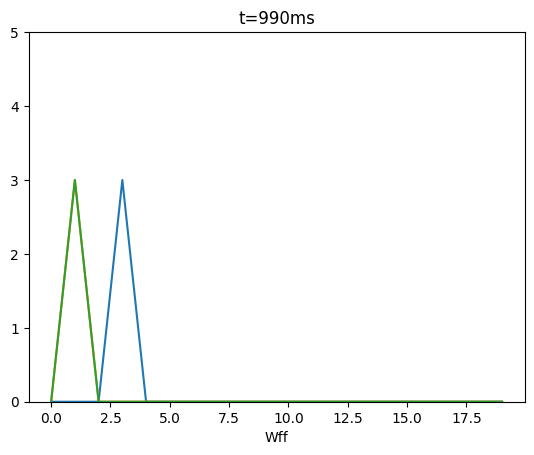

.


In [142]:
net.reset()

# plot
fig = plt.figure(figsize=(10, 4))

for t in range(T):

    net.step(Sj=Sj[t])

    #plt.clf()
    if t%10 == 0:
        clf()
        for i in range(N):
            plt.plot(range(Nj), net.Wff[i])
        plt.xlabel("Wff")
        plt.title(f"t={t}ms")
        plt.ylim((0, 5))
        plt.pause(0.001)

print(".")